## Opta Data Extraction

### Orion Sports GTM Player Performance Application

Thomson Rajan

May 2024

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, lit
from pyspark.sql.types import StructType, ArrayType

import json

## MA3 Extraction - Match Events

In [54]:
# create spark session

spark = SparkSession.builder.appName("OptaDataImport").getOrCreate()

# Read the JSON file
ma3 = spark.read.json("opta_data/MA3_2021_09_11.json")

In [55]:
ma3.printSchema()


root
 |-- liveData: struct (nullable = true)
 |    |-- event: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- assist: long (nullable = true)
 |    |    |    |-- contestantId: string (nullable = true)
 |    |    |    |-- eventId: long (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- keyPass: long (nullable = true)
 |    |    |    |-- lastModified: string (nullable = true)
 |    |    |    |-- outcome: long (nullable = true)
 |    |    |    |-- periodId: long (nullable = true)
 |    |    |    |-- playerId: string (nullable = true)
 |    |    |    |-- playerName: string (nullable = true)
 |    |    |    |-- qualifier: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |    |-- qualifierId: long (nullable = true)
 |    |    |    |    |    |-- value: string (nullable = true)
 |    |    |    |-- t

In [56]:
ma3.show(truncate=True)

+--------------------+--------------------+
|            liveData|           matchInfo|
+--------------------+--------------------+
|{[{NULL, 75xi6hlo...|{Limited Audience...|
+--------------------+--------------------+



In [57]:
# Get event data 

# Explode liveData.event array
live_data_event_df = ma3.select(explode("liveData.event").alias("event"))

# Assuming live_data_event_df is your DataFrame
qualifiers_df = live_data_event_df.select(
    "event.*",
    explode("event.qualifier").alias("qualifiers")
)

# Select fields from qualifiers
event_df = qualifiers_df.select(
    col("id"), 
    col("assist"), 
    col("contestantId"), 
    col("eventId"), 
    col("keyPass"), 
    col("lastModified"), 
    col("outcome"), 
    col("periodId"), 
    col("playerId"), 
    col("playerName"), 
    col("timeMin"), 
    col("timeSec"), 
    col("timeStamp"), 
    col("typeId"), 
    col("x"), 
    col("y"), 
    col("qualifiers.id").alias("qualifierID"), 
    col("qualifiers.qualifierId").alias("qualifiertype"), 
    col("qualifiers.value")
)

In [58]:
# Show the resulting DataFrame
event_df.show()

+----------+------+--------------------+-------+-------+--------------------+-------+--------+--------------------+--------------+-------+-------+--------------------+------+----+----+-----------+-------------+--------------------+
|        id|assist|        contestantId|eventId|keyPass|        lastModified|outcome|periodId|            playerId|    playerName|timeMin|timeSec|           timeStamp|typeId|   x|   y|qualifierID|qualifiertype|               value|
+----------+------+--------------------+-------+-------+--------------------+-------+--------+--------------------+--------------+-------+-------+--------------------+------+----+----+-----------+-------------+--------------------+
|2328542063|  NULL|75xi6hloabmnjn2kz...|      1|   NULL|2021-09-11T17:39:10Z|      1|      16|                NULL|          NULL|      0|      0|2021-09-11T17:39:...|    34| 0.0| 0.0| 3087870323|          130|                   4|
|2328542063|  NULL|75xi6hloabmnjn2kz...|      1|   NULL|2021-09-11T17:39

In [59]:
# Flatten liveData.matchDetails structure
match_details_df = ma3.select("liveData.matchDetails.*")

match_details_df.show()

+--------------+--------------+-----------+--------------------+--------+--------------------+------+
|matchLengthMin|matchLengthSec|matchStatus|              period|periodId|              scores|winner|
+--------------+--------------+-----------+--------------------+--------+--------------------+------+
|            97|            41|     Played|[{2021-09-11T19:1...|      14|{{1, 2}, {0, 0}, ...|  home|
+--------------+--------------+-----------+--------------------+--------+--------------------+------+



In [60]:
# # Get match details
ma3_match_score = match_details_df.select(
    match_details_df.matchLengthMin.alias("match_length_min"),
    match_details_df.matchLengthSec.alias("match_length_sec"),
    match_details_df.matchStatus.alias("match_status"),
    match_details_df.periodId.alias("period_id"),
    match_details_df.winner.alias("winner"),
    match_details_df.scores.ft.away.alias("ft_away"),
    match_details_df.scores.ft.home.alias("ft_home"),
    match_details_df.scores.ht.away.alias("ht_away"),
    match_details_df.scores.ht.home.alias("ht_home"),
    match_details_df.scores.total.away.alias("total_away"),
    match_details_df.scores.total.home.alias("total_home")
)
# Show the resulting DataFrame
ma3_match_score.show()

# • 1 (First half)
# • 2 (Second half)
# • 3 (Extra time - first half)
# • 4 (Extra time - second half)
# • 5 (Penalty shootout)
# • 10 (Half time)
# • 11 (End of second half - before extra time)
# • 12 (Extra time half time)
# • 13 (End of extra time - before penalties)
# • 14 (Full time)
# • 16 (Pre-match)

+----------------+----------------+------------+---------+------+-------+-------+-------+-------+----------+----------+
|match_length_min|match_length_sec|match_status|period_id|winner|ft_away|ft_home|ht_away|ht_home|total_away|total_home|
+----------------+----------------+------------+---------+------+-------+-------+-------+-------+----------+----------+
|              97|              41|      Played|       14|  home|      1|      2|      0|      0|         1|         2|
+----------------+----------------+------------+---------+------+-------+-------+-------+-------+----------+----------+



In [61]:
# Get Period details
exploded_period_df = match_details_df.select(
    explode("period").alias("period_exploded")
)

# Selecting and aliasing fields from the exploded contestant array
ma3_match_period = exploded_period_df.select(
    col("period_exploded.id").alias("periodID"),
    "period_exploded.lengthMin",
    "period_exploded.lengthSec",
    "period_exploded.start",
    "period_exploded.end"
)

# Show the resulting DataFrame
ma3_match_period.show(truncate=False)

+--------+---------+---------+--------------------+--------------------+
|periodID|lengthMin|lengthSec|start               |end                 |
+--------+---------+---------+--------------------+--------------------+
|1       |45       |2        |2021-09-11T18:30:06Z|2021-09-11T19:15:08Z|
|2       |52       |39       |2021-09-11T19:34:13Z|2021-09-11T20:26:52Z|
+--------+---------+---------+--------------------+--------------------+



In [62]:
# Flatten matchInfo structure
match_info_df = ma3.select("matchInfo.*")

match_info_df.show()

+----------------+----------------+--------------------+--------------------+-------------+-----------+--------------------+--------------------+--------------------+----------+---------+---------------+------------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+----+
|  attendanceInfo|attendanceInfoId|         competition|          contestant|coverageLevel|       date|         description|                  id|         lastUpdated| localDate|localTime|numberOfPeriods|periodLength|             ruleset|               sport|               stage|     time|  tournamentCalendar|               venue|week|
+----------------+----------------+--------------------+--------------------+-------------+-----------+--------------------+--------------------+--------------------+----------+---------+---------------+------------+--------------------+--------------------+--------------------+---------+--------------------+----------------

In [63]:

# Extracting and aliasing the necessary fields directly from match_info_df
ma3_match_info = match_info_df.select(
    col("attendanceInfo").alias("attendance_info"),
    col("attendanceInfoId").alias("attendance_info_id"),
    col("competition.competitionCode").alias("competition_code"),
    col("competition.competitionFormat").alias("competition_format"),
    col("competition.country.id").alias("competition_country_id"),
    col("competition.country.name").alias("competition_country_name"),
    col("competition.id").alias("competition_id"),
    col("competition.knownName").alias("competition_known_name"),
    col("competition.name").alias("competition_name"),
    col("coverageLevel").alias("coverage_level"),
    col("date").alias("date"),
    col("description").alias("description"),
    col("id").alias("id"),
    col("lastUpdated").alias("last_updated"),
    col("localDate").alias("local_date"),
    col("localTime").alias("local_time"),
    col("numberOfPeriods").alias("number_of_periods"),
    col("periodLength").alias("period_length"),
    col("ruleset.id").alias("ruleset_id"),
    col("ruleset.name").alias("ruleset_name"),
    col("sport.id").alias("sport_id"),
    col("sport.name").alias("sport_name"),
    col("stage.endDate").alias("stage_end_date"),
    col("stage.formatId").alias("stage_format_id"),
    col("stage.id").alias("stage_id"),
    col("stage.name").alias("stage_name"),
    col("stage.startDate").alias("stage_start_date"),
    col("time").alias("time"),
    col("tournamentCalendar.endDate").alias("tournament_calendar_end_date"),
    col("tournamentCalendar.id").alias("tournament_calendar_id"),
    col("tournamentCalendar.name").alias("tournament_calendar_name"),
    col("tournamentCalendar.startDate").alias("tournament_calendar_start_date"),
    col("venue.id").alias("venue_id"),
    col("venue.longName").alias("venue_long_name"),
    col("venue.neutral").alias("venue_neutral"),
    col("venue.shortName").alias("venue_short_name"),
    col("week").alias("week")
)

# Show the resulting DataFrame
ma3_match_info.show(truncate=False)

+----------------+------------------+----------------+------------------+-------------------------+------------------------+-------------------------+----------------------+----------------+--------------+-----------+--------------------------+-------------------------+--------------------+----------+----------+-----------------+-------------+-------------------------+------------+-------------------------+----------+--------------+-------------------------+-------------------------+--------------+----------------+---------+----------------------------+-------------------------+------------------------+------------------------------+------------------------+----------------+-------------+----------------+----+
|attendance_info |attendance_info_id|competition_code|competition_format|competition_country_id   |competition_country_name|competition_id           |competition_known_name|competition_name|coverage_level|date       |description               |id                       |last_updat

In [64]:
# Explode the contestant array to handle nested struct
exploded_contestant_df = match_info_df.select(
    explode("contestant").alias("contestant_exploded")
)

# Get contestant details
ma3_match_contestant = exploded_contestant_df.select(
    "contestant_exploded.code",
    "contestant_exploded.country.id",
    "contestant_exploded.country.name",
    col("contestant_exploded.id").alias("contestant_id"),
    col("contestant_exploded.name").alias("team_name"),
    "contestant_exploded.officialName",
    "contestant_exploded.position",
    "contestant_exploded.shortName"
)

# Show the resulting DataFrame
ma3_match_contestant.show(truncate=False)

+----+-------------------------+-------+-------------------------+------------+-------------+--------+----------+
|code|id                       |name   |id                       |name        |officialName |position|shortName |
+----+-------------------------+-------+-------------------------+------------+-------------+--------+----------+
|HSV |36min0qztu8eydwvpv8t1is0m|Germany|75xi6hloabmnjn2kzgj1g8h1s|Hamburger SV|Hamburger SV |home    |Hamburg   |
|SVS |36min0qztu8eydwvpv8t1is0m|Germany|884uzyf1wosc7ykji6e18gifp|Sandhausen  |SV Sandhausen|away    |Sandhausen|
+----+-------------------------+-------+-------------------------+------------+-------------+--------+----------+



### Associate Event and Qualifier ID detail to events

In [65]:
# Get event type and qualifier type data
event_types = spark.read.csv("XML_Definitions_eventtypes.csv", header=True, inferSchema=True, encoding="latin1")

qualifier_types = spark.read.csv("MA3_qualifiertypes.csv", header=True, inferSchema=True)


In [66]:
# rename to avoid duplication
event_types = event_types.withColumnRenamed("Description", "Event Description")

qualifier_types = qualifier_types.withColumnRenamed("DESCRIPTION", "Qualifier Description")

In [67]:
qualifier_types.show()

+-----------+--------------------+---------------------+------------------------------+
|qualifierId|      QUALIFIER NAME|Qualifier Description|ASSOCIATED EVENT typeId VALUES|
+-----------+--------------------+---------------------+------------------------------+
|          1|           Long ball| A pass over 32 me...|                          1, 2|
|          2|               Cross| A ball played in ...|                          1, 2|
|          3|           Head pass| A pass made with ...|                          1, 2|
|          4|        Through ball| Ball played throu...|                          1, 2|
|          5|     Free kick taken| Any free kick tak...|                          1, 2|
|          6|        Corner taken| All corners taken...|                          1, 2|
|          7|Players caught of...| The player was in...|                             2|
|          8|     Goal disallowed| Pass led to a goa...|                             2|
|          9|             Penalt

In [68]:
# rename to match event_df
event_types = event_types.withColumnRenamed("Event ID", "eventId")
# rename to match event_df
qualifier_types = qualifier_types.withColumnRenamed("qualifierId", "qualifiertype")

In [69]:
event_types.show()


+-------+--------------+--------------------+
|eventId|          Name|   Event Description|
+-------+--------------+--------------------+
|      1|          Pass|Any pass attempte...|
|      2|  Offside Pass|Attempted pass ma...|
|      3|       Take On|Attempted dribble...|
|      4|          Foul|This event ID sho...|
|      5|           Out|Shown each time t...|
|      6|Corner Awarded|Ball goes out of ...|
|      7|        Tackle|Tackle = disposse...|
|      8|  Interception|When a player int...|
|      9|      Turnover|Unforced error / ...|
|     10|          Save|Goalkeeper event;...|
|     11|         Claim|Goalkeeper event;...|
|     12|     Clearance|Player under pres...|
|     13|          Miss|Any shot on goal ...|
|     14|          Post|Whenever the ball...|
|     15| Attempt Saved|Shot saved - this...|
|     16|          Goal|           All goals|
|     17|          Card|Bookings - will h...|
|     18|    Player Off|Player is substit...|
|     19|     Player on|Player com

In [70]:
# Joining dfs to get event type data
joined_df = event_df.join(event_types, ["eventID"])


In [71]:
# Joining dfs to get qualifier type data
ma3_match_events = joined_df.join(qualifier_types, ["qualifiertype"])

In [72]:
ma3_match_events.show()

+-------------+-------+----------+------+--------------------+-------+--------------------+-------+--------+--------------------+--------------+-------+-------+--------------------+------+----+----+-----------+--------------------+------------+--------------------+--------------------+---------------------+------------------------------+
|qualifiertype|eventId|        id|assist|        contestantId|keyPass|        lastModified|outcome|periodId|            playerId|    playerName|timeMin|timeSec|           timeStamp|typeId|   x|   y|qualifierID|               value|        Name|   Event Description|      QUALIFIER NAME|Qualifier Description|ASSOCIATED EVENT typeId VALUES|
+-------------+-------+----------+------+--------------------+-------+--------------------+-------+--------+--------------------+--------------+-------+-------+--------------------+------+----+----+-----------+--------------------+------------+--------------------+--------------------+---------------------+------------

In [73]:
# Save DataFrame as a table
ma3_match_events.createOrReplaceTempView("my_table")



In [74]:
# Query data from the temporary view
query_result = spark.sql("SELECT * FROM my_table AS t WHERE t.eventId = 1")

# Show the result of the query
query_result.show()


+-------------+-------+----------+------+--------------------+-------+--------------------+-------+--------+--------+----------+-------+-------+--------------------+------+---+---+-----------+--------------------+----+--------------------+--------------------+---------------------+------------------------------+
|qualifiertype|eventId|        id|assist|        contestantId|keyPass|        lastModified|outcome|periodId|playerId|playerName|timeMin|timeSec|           timeStamp|typeId|  x|  y|qualifierID|               value|Name|   Event Description|      QUALIFIER NAME|Qualifier Description|ASSOCIATED EVENT typeId VALUES|
+-------------+-------+----------+------+--------------------+-------+--------------------+-------+--------+--------+----------+-------+-------+--------------------+------+---+---+-----------+--------------------+----+--------------------+--------------------+---------------------+------------------------------+
|          130|      1|2328542063|  NULL|75xi6hloabmnjn2kz

### Export to CSV

In [75]:
# Export DataFrames to CSV

# Event data
events = ma3_match_events.toPandas()
events.to_csv("ma3_match_events.csv")

# Match score data
score = ma3_match_score.toPandas()
score.to_csv("ma3_match_score.csv")

# match info data
info = ma3_match_info.toPandas()
info.to_csv("ma3_match_info.csv")

# Match Period details data
period = ma3_match_period.toPandas()
period.to_csv("ma3_match_period.csv")

# Match Contestant data
cont = ma3_match_contestant.toPandas()
cont.to_csv("ma3_match_contestant.csv")



In [76]:
# Stop the Spark session
spark.stop()

### Inisghts from match

In [77]:
events.head()

,qualifiertype,eventId,id,assist,contestantId,keyPass,lastModified,outcome,periodId,playerId,...,typeId,x,y,qualifierID,value,Name,Event Description,QUALIFIER NAME,Qualifier Description,ASSOCIATED EVENT typeId VALUES
0,130,1,2328542063,NaN,75xi6hloabmnjn2kzgj1g8h1s,NaN,2021-09-11T17:39:10Z,1,16,None,...,34,0.0,0.0,3087870323,4,Pass,Any pass attempted from one player to another ...,Team Formation,The formation the team played. The value is th...,"34, 40"
1,30,1,2328542063,NaN,75xi6hloabmnjn2kzgj1g8h1s,NaN,2021-09-11T17:39:10Z,1,16,None,...,34,0.0,0.0,3087870311,"8b60vtt1stnmt2uoj0f4lh49h, ci4pwzieoc94uj3i137...",Pass,Any pass attempted from one player to another ...,Involved,A list of comma-separated Player IDs or Coach ...,"34, 40, 71"
2,194,1,2328542063,NaN,75xi6hloabmnjn2kzgj1g8h1s,NaN,2021-09-11T17:39:10Z,1,16,None,...,34,0.0,0.0,3087870335,do9g7p0jtcfngmvq1uzy2tqdx,Pass,Any pass attempted from one player to another ...,Captain,The player who is the team captain - the value...,"34, 40"
3,44,1,2328542063,NaN,75xi6hloabmnjn2kzgj1g8h1s,NaN,2021-09-11T17:39:10Z,1,16,None,...,34,0.0,0.0,3087870315,"1, 2, 2, 3, 2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5...",Pass,Any pass attempted from one player to another ...,Player position,The position of the player(s) in the team form...,"18, 19, 34, 40"
4,197,1,2328542063,NaN,75xi6hloabmnjn2kzgj1g8h1s,NaN,2021-09-11T17:39:10Z,1,16,None,...,34,0.0,0.0,3087870339,4938,Pass,Any pass attempted from one player to another ...,Team kit,The ID of the kit used by the team,34


In [78]:
events.describe()

,qualifiertype,eventId,id,assist,keyPass,outcome,periodId,timeMin,timeSec,typeId,x,y,qualifierID
count,818.000000,818.000000,8.180000e+02,0.0,31.0,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,8.180000e+02
mean,155.607579,38.330073,2.328593e+09,NaN,1.0,0.702934,1.293399,3.842298,29.779951,7.029340,44.091809,44.374572,3.089454e+09
std,83.658973,22.526820,7.694691e+03,NaN,0.0,0.457245,2.078503,3.037638,17.507487,13.003215,29.307471,32.440781,3.255865e+06
min,1.000000,1.000000,2.328542e+09,NaN,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,-1.600000,-2.000000,3.087870e+09
25%,76.750000,17.000000,2.328592e+09,NaN,1.0,0.000000,1.000000,1.000000,14.000000,1.000000,20.700000,11.000000,3.088134e+09
50%,152.000000,39.000000,2.328593e+09,NaN,1.0,1.000000,1.000000,3.000000,32.000000,1.000000,38.900000,42.000000,3.088148e+09
75%,212.000000,58.000000,2.328597e+09,NaN,1.0,1.000000,1.000000,7.000000,44.000000,5.000000,70.100000,73.600000,3.088166e+09
max,392.000000,77.000000,2.328600e+09,NaN,1.0,1.000000,16.000000,11.000000,59.000000,61.000000,101.500000,102.000000,3.098076e+09


In [79]:
# Count of different event types
event_counts = events['Name'].value_counts()
print(event_counts)

Name
Clearance          25
Collection End     23
Possession Data    20
Turnover           20
Shield ball opp    17
                   ..
Attempt Saved       6
Tackle              6
Player returns      4
Early end           3
Offside Pass        2
Name: count, Length: 70, dtype: int64


In [80]:
# Count of different qualifier types
qual_counts = events['QUALIFIER NAME'].value_counts()
print(event_counts)

Name
Clearance          25
Collection End     23
Possession Data    20
Turnover           20
Shield ball opp    17
                   ..
Attempt Saved       6
Tackle              6
Player returns      4
Early end           3
Offside Pass        2
Name: count, Length: 70, dtype: int64


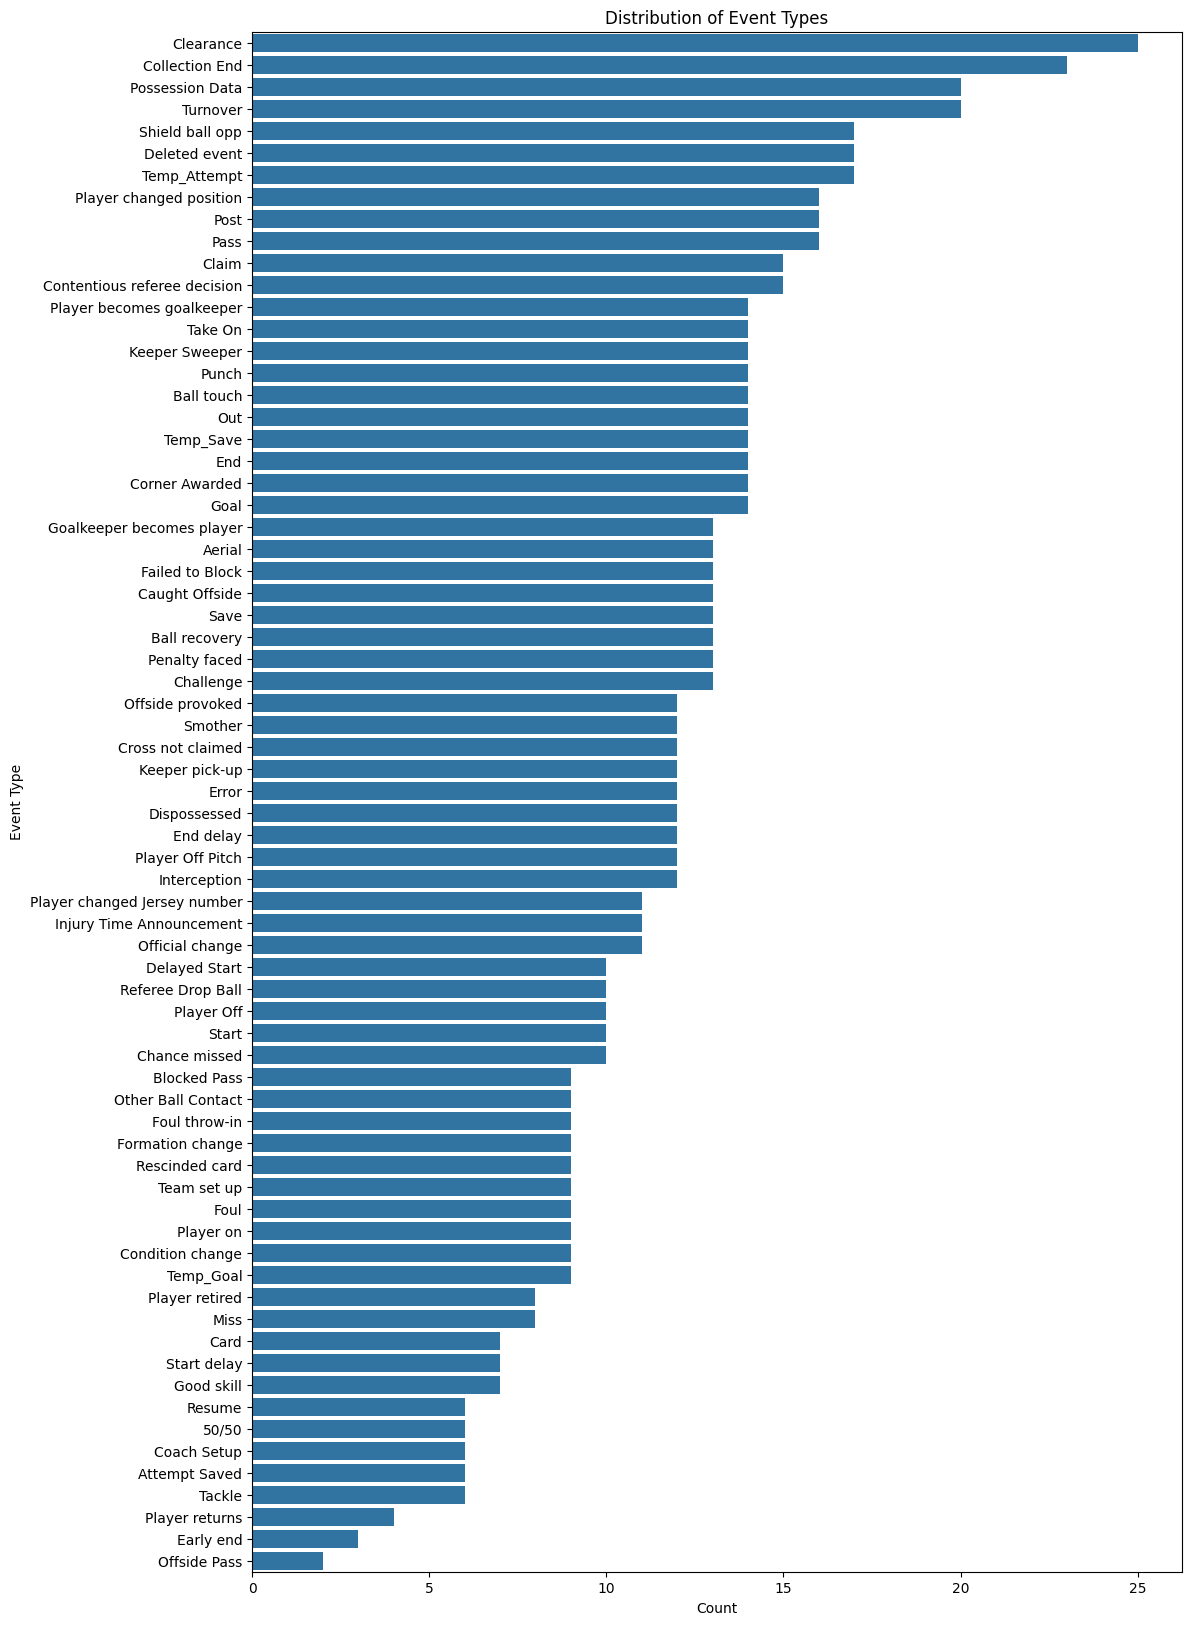

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of event types
plt.figure(figsize=(12, 20))
sns.countplot(data=events, y='Name', order=event_counts.index)
plt.title('Distribution of Event Types')
plt.xlabel('Count')
plt.ylabel('Event Type')
plt.show()


playerId
ehvnch6p70deczk99k156jglx    59
68u3vd1upyaz92c06d1ekpbyt    58
46vr35g415omy60ahbiv40wk5    57
dkf9v2y9a7ogw6k53crs6dc5x    56
do9g7p0jtcfngmvq1uzy2tqdx    55
Name: count, dtype: int64


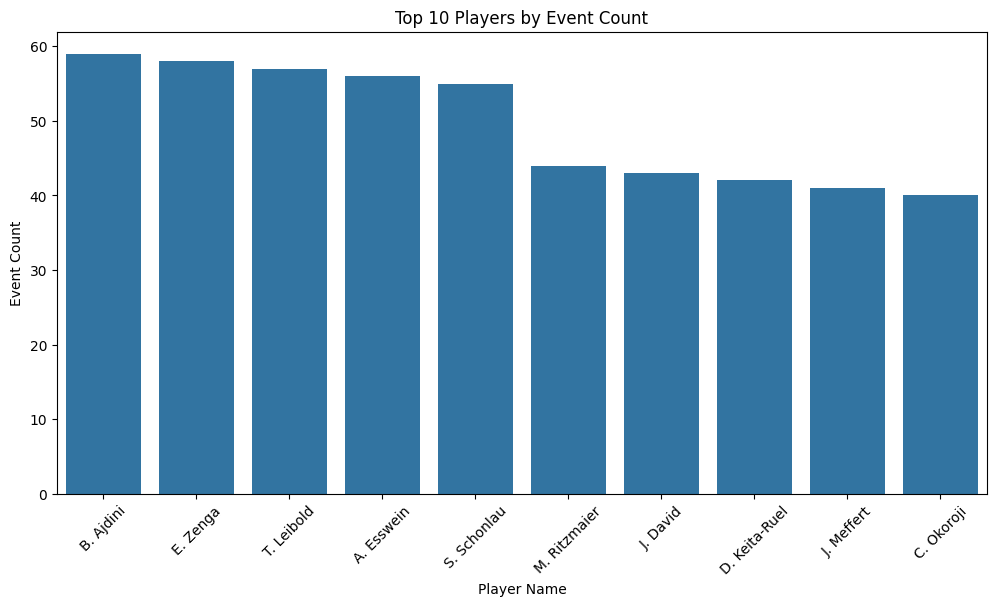

In [82]:
# Assuming playerId and playerName are available in the DataFrame
player_event_counts = events['playerId'].value_counts()
print(player_event_counts.head())

# Plot player performance (number of events per player)
top_players = player_event_counts.head(10).index
plt.figure(figsize=(12, 6))
sns.countplot(data=events[events['playerId'].isin(top_players)], x='playerName', order=events[events['playerId'].isin(top_players)]['playerName'].value_counts().index)
plt.title('Top 10 Players by Event Count')
plt.xlabel('Player Name')
plt.ylabel('Event Count')
plt.xticks(rotation=45)
plt.show()


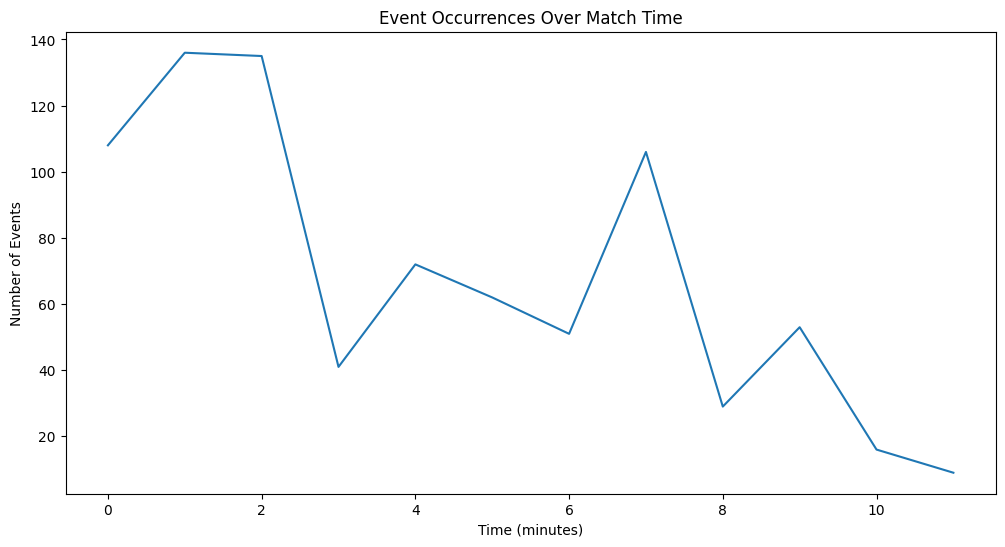

In [83]:
# Time-based analysis using a line chart
time_minute_counts = events['timeMin'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x=time_minute_counts.index, y=time_minute_counts.values)
plt.title('Event Occurrences Over Match Time')
plt.xlabel('Time (minutes)')
plt.ylabel('Number of Events')
plt.show()

C:\Users\Thomson.R\AppData\Local\Temp\ipykernel_5268\2885982269.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=events, x='x', y='y', cmap="Reds", shade=True, bw_adjust=0.5)


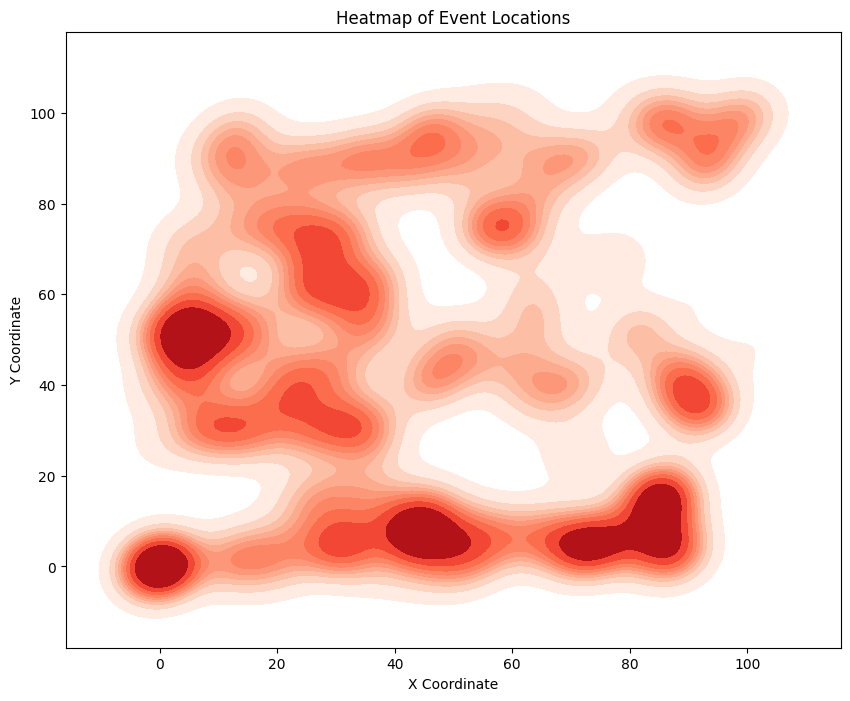

In [84]:
# Example: Heatmap of event locations (x, y coordinates)
plt.figure(figsize=(10, 8))
sns.kdeplot(data=events, x='x', y='y', cmap="Reds", shade=True, bw_adjust=0.5)
plt.title('Heatmap of Event Locations')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()


## MA4 Extraction - Pass Matrix and Average Formation

In [121]:
# create spark session

spark = SparkSession.builder.appName("OptaDataImport").getOrCreate()

# Read the JSON file
ma4 = spark.read.json("opta_data/MA4_2023_08_26.json")

In [86]:
ma4.printSchema()



root
 |-- liveData: struct (nullable = true)
 |    |-- lineUp: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- contestantId: string (nullable = true)
 |    |    |    |-- player: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- crossLost: long (nullable = true)
 |    |    |    |    |    |-- crossSuccess: long (nullable = true)
 |    |    |    |    |    |-- firstName: string (nullable = true)
 |    |    |    |    |    |-- lastName: string (nullable = true)
 |    |    |    |    |    |-- matchName: string (nullable = true)
 |    |    |    |    |    |-- passLost: long (nullable = true)
 |    |    |    |    |    |-- passSuccess: long (nullable = true)
 |    |    |    |    |    |-- playerId: string (nullable = true)
 |    |    |    |    |    |-- playerPass: array (nullable = true)
 |    |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |   

In [122]:
# Step 1: Explode the lineUp array to handle nested fields
exploded_lineup_df = ma4.select(
    explode("liveData.lineUp").alias("lineUp")
)

# Step 2: Explode the player array within each lineUp element
exploded_player_df = exploded_lineup_df.select(
    col("lineUp.contestantId").alias("contestant_id"),
    explode("lineUp.player").alias("player")  # Exploding the player array
)

# Extract player passing
ma4_player_pass_df = exploded_player_df.select(
    col("contestant_id"),
    col("player.crossLost").alias("cross_lost"),
    col("player.crossSuccess").alias("cross_success"),
    col("player.firstName").alias("player_first_name"),
    col("player.lastName").alias("player_last_name"),
    col("player.matchName").alias("player_match_name"),
    col("player.passLost").alias("pass_lost"),
    col("player.passSuccess").alias("pass_success"),
    col("player.playerId").alias("player_id"),
    col("player.position").alias("player_position"),
    col("player.positionSide").alias("player_position_side"),
    col("player.shirtNumber").alias("player_shirt_number"),
    col("player.shortFirstName").alias("player_short_first_name"),
    col("player.shortLastName").alias("player_short_last_name"),
    col("player.x").alias("player_x"),
    col("player.y").alias("player_y"),
    col("player.playerPass.cross").alias("player_pass_cross"),
    col("player.playerPass.firstName").alias("player_pass_first_name"),
    col("player.playerPass.lastName").alias("player_pass_last_name"),
    col("player.playerPass.matchName").alias("player_pass_match_name"),
    col("player.playerPass.playerId").alias("player_pass_id"),
    col("player.playerPass.shortFirstName").alias("player_pass_short_first_name"),
    col("player.playerPass.shortLastName").alias("player_pass_short_last_name"),
    col("player.playerPass.value").alias("player_pass_value")
)

# Extract Coach details separately
ma4_coach_details = exploded_lineup_df.select(
    col("lineUp.teamOfficial.firstName").alias("official_first_name"),
    col("lineUp.teamOfficial.id").alias("official_id"),
    col("lineUp.teamOfficial.lastName").alias("official_last_name"),
    col("lineUp.teamOfficial.shortFirstName").alias("official_short_first_name"),
    col("lineUp.teamOfficial.shortLastName").alias("official_short_last_name"),
    col("lineUp.teamOfficial.type").alias("official_type")
)



In [88]:
num_rows = ma4_player_pass_df.count()
num_columns = len(ma4_player_pass_df.columns)
print(f"Number of rows: {num_rows}, Number of columns: {num_columns}")

Number of rows: 39, Number of columns: 24


In [117]:
# Show the resulting DataFrame
ma4_player_pass_df.show()


+--------------------+----------+-------------+-----------------+----------------+-----------------+---------+------------+--------------------+--------------------+--------------------+-------------------+-----------------------+----------------------+--------+--------+--------------------+----------------------+---------------------+----------------------+--------------------+----------------------------+---------------------------+--------------------+
|       contestant_id|cross_lost|cross_success|player_first_name|player_last_name|player_match_name|pass_lost|pass_success|           player_id|     player_position|player_position_side|player_shirt_number|player_short_first_name|player_short_last_name|player_x|player_y|   player_pass_cross|player_pass_first_name|player_pass_last_name|player_pass_match_name|      player_pass_id|player_pass_short_first_name|player_pass_short_last_name|   player_pass_value|
+--------------------+----------+-------------+-----------------+---------------

In [90]:

ma4_coach_details.show()

+-------------------+--------------------+------------------+-------------------------+------------------------+-------------+
|official_first_name|         official_id|official_last_name|official_short_first_name|official_short_last_name|official_type|
+-------------------+--------------------+------------------+-------------------------+------------------------+-------------+
|              Horst|eti6exxngiuilj1ft...|           Steffen|                    Horst|                 Steffen|      manager|
|             Daniel|bt34e09okuoj7oegz...|           Thioune|                   Daniel|                 Thioune|      manager|
+-------------------+--------------------+------------------+-------------------------+------------------------+-------------+



In [123]:
num_rows = ma4_coach_details.count()
num_columns = len(ma4_coach_details.columns)
print(f"Number of rows: {num_rows}, Number of columns: {num_columns}")

Number of rows: 2, Number of columns: 6


In [124]:
# Flatten liveData.matchDetails structure
match_details_df = ma4.select("liveData.matchDetails.*")

match_details_df.show()

+--------------+--------------+-----------+--------------------+--------+--------------------+------+
|matchLengthMin|matchLengthSec|matchStatus|              period|periodId|              scores|winner|
+--------------+--------------+-----------+--------------------+--------+--------------------+------+
|            98|            13|     Played|[{180, 2023-08-26...|      14|{{5, 0}, {3, 0}, ...|  away|
+--------------+--------------+-----------+--------------------+--------+--------------------+------+



In [125]:
# Get match details
ma4_match_score = match_details_df.select(
    match_details_df.matchLengthMin.alias("match_length_min"),
    match_details_df.matchLengthSec.alias("match_length_sec"),
    match_details_df.matchStatus.alias("match_status"),
    match_details_df.periodId.alias("period_id"),
    match_details_df.winner.alias("winner"),
    match_details_df.scores.ft.away.alias("ft_away"),
    match_details_df.scores.ft.home.alias("ft_home"),
    match_details_df.scores.ht.away.alias("ht_away"),
    match_details_df.scores.ht.home.alias("ht_home"),
    match_details_df.scores.total.away.alias("total_away"),
    match_details_df.scores.total.home.alias("total_home")
)
# Show the resulting DataFrame
ma4_match_score.show()

+----------------+----------------+------------+---------+------+-------+-------+-------+-------+----------+----------+
|match_length_min|match_length_sec|match_status|period_id|winner|ft_away|ft_home|ht_away|ht_home|total_away|total_home|
+----------------+----------------+------------+---------+------+-------+-------+-------+-------+----------+----------+
|              98|              13|      Played|       14|  away|      5|      0|      3|      0|         5|         0|
+----------------+----------------+------------+---------+------+-------+-------+-------+-------+----------+----------+



In [126]:
# Get Period details
exploded_period_df = match_details_df.select(
    explode("period").alias("period_exploded")
)

# Selecting and aliasing fields from the exploded contestant array
ma4_match_period = exploded_period_df.select(
    col("period_exploded.id").alias("periodID"),
    "period_exploded.announcedInjuryTime",
    "period_exploded.lengthMin",
    "period_exploded.lengthSec",
    "period_exploded.start",
    "period_exploded.end"
)

# Show the resulting DataFrame
ma4_match_period.show(truncate=False)

+--------+-------------------+---------+---------+--------------------+--------------------+
|periodID|announcedInjuryTime|lengthMin|lengthSec|start               |end                 |
+--------+-------------------+---------+---------+--------------------+--------------------+
|1       |180                |48       |4        |2023-08-26T11:00:21Z|2023-08-26T11:48:25Z|
|2       |300                |50       |9        |2023-08-26T12:07:07Z|2023-08-26T12:57:16Z|
+--------+-------------------+---------+---------+--------------------+--------------------+



In [127]:
# Flatten matchInfo structure
match_info_df = ma4.select("matchInfo.*")

match_info_df.show()

+--------------------+--------------------+-------------+-----------+--------------------+--------------------+--------------------+----------+---------+---------------+------------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+----+
|         competition|          contestant|coverageLevel|       date|         description|                  id|         lastUpdated| localDate|localTime|numberOfPeriods|periodLength|             ruleset|               sport|               stage|     time|  tournamentCalendar|               venue|week|
+--------------------+--------------------+-------------+-----------+--------------------+--------------------+--------------------+----------+---------+---------------+------------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+----+
|{2.B, Domestic le...|[{ELV, {36min0qzt...|           15|2023-08-26Z|Elversberg vs For...|4

In [128]:
# Extracting and aliasing the necessary fields directly from match_info_df
ma4_match_info = match_info_df.select(
    col("competition.competitionCode").alias("competition_code"),
    col("competition.competitionFormat").alias("competition_format"),
    col("competition.country.id").alias("competition_country_id"),
    col("competition.country.name").alias("competition_country_name"),
    col("competition.id").alias("competition_id"),
    col("competition.knownName").alias("competition_known_name"),
    col("competition.name").alias("competition_name"),
    col("coverageLevel").alias("coverage_level"),
    col("date").alias("date"),
    col("description").alias("description"),
    col("id").alias("id"),
    col("lastUpdated").alias("last_updated"),
    col("localDate").alias("local_date"),
    col("localTime").alias("local_time"),
    col("numberOfPeriods").alias("number_of_periods"),
    col("periodLength").alias("period_length"),
    col("ruleset.id").alias("ruleset_id"),
    col("ruleset.name").alias("ruleset_name"),
    col("sport.id").alias("sport_id"),
    col("sport.name").alias("sport_name"),
    col("stage.endDate").alias("stage_end_date"),
    col("stage.formatId").alias("stage_format_id"),
    col("stage.id").alias("stage_id"),
    col("stage.name").alias("stage_name"),
    col("stage.startDate").alias("stage_start_date"),
    col("time").alias("time"),
    col("tournamentCalendar.endDate").alias("tournament_calendar_end_date"),
    col("tournamentCalendar.id").alias("tournament_calendar_id"),
    col("tournamentCalendar.name").alias("tournament_calendar_name"),
    col("tournamentCalendar.startDate").alias("tournament_calendar_start_date"),
    col("venue.id").alias("venue_id"),
    col("venue.longName").alias("venue_long_name"),
    col("venue.neutral").alias("venue_neutral"),
    col("venue.shortName").alias("venue_short_name"),
    col("week").alias("week")
)

# Show the resulting DataFrame
ma4_match_info.show(truncate=False)

+----------------+------------------+-------------------------+------------------------+-------------------------+----------------------+----------------+--------------+-----------+--------------------------------+-------------------------+--------------------+----------+----------+-----------------+-------------+-------------------------+------------+-------------------------+----------+--------------+-------------------------+-------------------------+--------------+----------------+---------+----------------------------+-------------------------+------------------------+------------------------------+------------------------+----------------------------------+-------------+----------------------------------+----+
|competition_code|competition_format|competition_country_id   |competition_country_name|competition_id           |competition_known_name|competition_name|coverage_level|date       |description                     |id                       |last_updated        |local_date|lo

In [130]:
# Explode the contestant array to handle nested struct
exploded_contestant_df = match_info_df.select(
    explode("contestant").alias("contestant_exploded")
)

# Get contestant details
ma4_match_contestant = exploded_contestant_df.select(
    "contestant_exploded.code",
    "contestant_exploded.country.id",
    "contestant_exploded.country.name",
    col("contestant_exploded.id").alias("contestant_id"),
    col("contestant_exploded.name").alias("team_name"),
    "contestant_exploded.officialName",
    "contestant_exploded.position",
    "contestant_exploded.shortName"
)

# Show the resulting DataFrame
ma4_match_contestant.show(truncate=False)

+----+-------------------------+-------+-------------------------+------------------+-----------------------------+--------+----------+
|code|id                       |name   |contestant_id            |team_name         |officialName                 |position|shortName |
+----+-------------------------+-------+-------------------------+------------------+-----------------------------+--------+----------+
|ELV |36min0qztu8eydwvpv8t1is0m|Germany|cig09m7g3wx983agnqgovggoh|Elversberg        |SV 07 Elversberg             |home    |Elversberg|
|F95 |36min0qztu8eydwvpv8t1is0m|Germany|8cf22o379ziez932kkzoi1d8q|Fortuna Düsseldorf|Düsseldorfer TuS Fortuna 1895|away    |Düsseldorf|
+----+-------------------------+-------+-------------------------+------------------+-----------------------------+--------+----------+



#### Connect player data to team name

In [136]:
# Add team name to pass matrix and formation
ma4_player_pass_df = ma4_player_pass_df.join(
    ma4_match_contestant.select("contestant_id", "team_name"),
    on="contestant_id",
    how="left"
)

In [139]:
ma4_player_pass_df.show(truncate=False)

+-------------------------+----------+-------------+-----------------+----------------+-----------------+---------+------------+-------------------------+--------------------+--------------------+-------------------+-----------------------+----------------------+--------+--------+------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

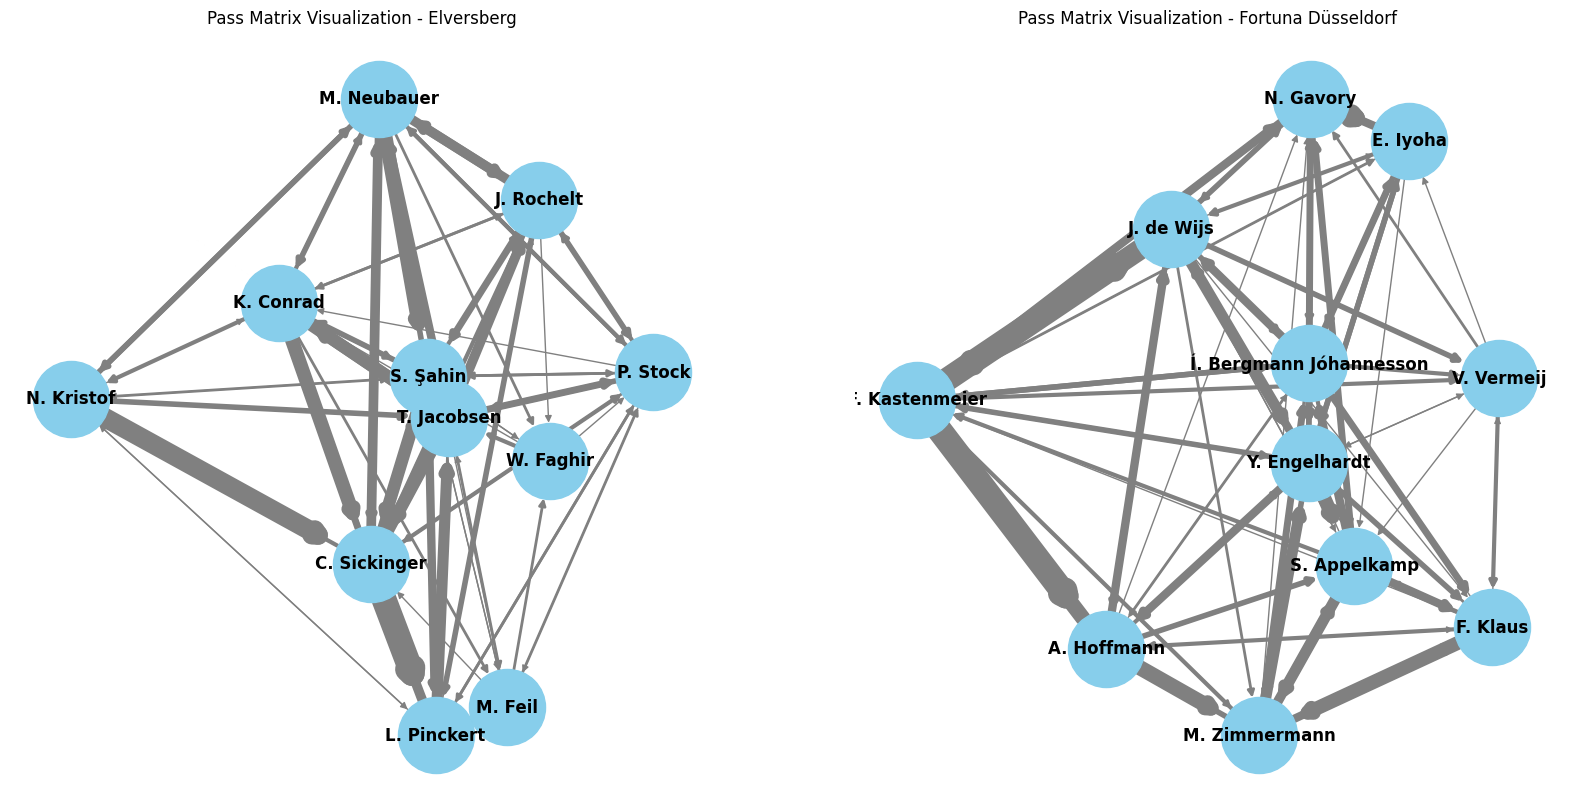

In [142]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Assuming your Spark DataFrame is named ma4_player_pass_df
ma4_player_pass_pd = ma4_player_pass_df.toPandas()

# Filter out 'Substitute' player positions
ma4_player_pass_pd = ma4_player_pass_pd[ma4_player_pass_pd['player_position'] != 'Substitute']

# Filter the DataFrame by team_name
teams = ma4_player_pass_pd['team_name'].unique()
team_graphs = {}

for team in teams:
    team_data = ma4_player_pass_pd[ma4_player_pass_pd['team_name'] == team]
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes
    for _, row in team_data.iterrows():
        if not pd.isna(row['player_x']) and not pd.isna(row['player_y']):
            G.add_node(row['player_match_name'], pos=(row['player_x'], row['player_y']))
    
    # Add edges
    for _, row in team_data.iterrows():
        player_from = row['player_match_name']
        if row['player_pass_match_name'] is not None:  # Check if the value is not None
            for i, player_to in enumerate(row['player_pass_match_name']):
                if player_to and player_to in G.nodes:  # Check for None or empty values and if the node exists
                    G.add_edge(player_from, player_to, weight=row['player_pass_value'][i])
    
    team_graphs[team] = G

# Plot the graphs
plt.figure(figsize=(20, 10))

for i, (team, G) in enumerate(team_graphs.items(), 1):
    pos = nx.get_node_attributes(G, 'pos')
    
    plt.subplot(1, len(teams), i)
    edges = G.edges(data=True)
    weights = [d['weight'] for (u, v, d) in edges]
    
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=12, font_weight='bold', edge_color='gray', width=weights)
    
    plt.title(f'Pass Matrix Visualization - {team}')

plt.show()


### Export to CSV

In [106]:
# Export DataFrames to CSV

# Pass Matrix and Average Formation data
passmatrix = ma4_player_pass_df.toPandas()
passmatrix.to_csv("ma4_player_pass_df.csv")

# Match Coach data
coach = ma4_coach_details.toPandas()
coach.to_csv("ma4_coach_details.csv")

# match score data
score = ma4_match_score.toPandas()
score.to_csv("ma4_match_score.csv")

# match info data
info = ma4_match_info.toPandas()
info.to_csv("ma4_match_info.csv")

# Match Period details data
period = ma4_match_period.toPandas()
period.to_csv("ma4_match_period.csv")

# Match Contestant data
cont = ma4_match_contestant.toPandas()
cont.to_csv("ma4_match_contestant.csv")



In [ ]:
# Stop the Spark session
spark.stop()

## MA5 Extraction - Possession data

In [4]:
# create spark session

spark = SparkSession.builder.appName("OptaDataImport").getOrCreate()

# Read the JSON file
ma5 = spark.read.json("opta_data/MA5_2023_08_26.json")

In [17]:
ma5.printSchema()

root
 |-- liveData: struct (nullable = true)
 |    |-- matchDetails: struct (nullable = true)
 |    |    |-- matchLengthMin: long (nullable = true)
 |    |    |-- matchLengthSec: long (nullable = true)
 |    |    |-- matchStatus: string (nullable = true)
 |    |    |-- period: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- announcedInjuryTime: long (nullable = true)
 |    |    |    |    |-- end: string (nullable = true)
 |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |-- lengthMin: long (nullable = true)
 |    |    |    |    |-- lengthSec: long (nullable = true)
 |    |    |    |    |-- start: string (nullable = true)
 |    |    |-- periodId: long (nullable = true)
 |    |    |-- scores: struct (nullable = true)
 |    |    |    |-- ft: struct (nullable = true)
 |    |    |    |    |-- away: long (nullable = true)
 |    |    |    |    |-- home: long (nullable = true)
 |    |    |    |-- ht: struct (null

In [5]:

# Assuming ma5 is your Spark DataFrame
# Step 1: Explode possessionWave
exploded_possession_wave_df = ma5.select(
    col("liveData.possession.possessionWave.overall.away").alias("overall_away"),
    col("liveData.possession.possessionWave.overall.home").alias("overall_home"),
    col("liveData.possession.possessionWave.overall.middle").alias("overall_middle"),
    explode("liveData.possession.possessionWave").alias("possessionWave")  
)

# Step 2: Explode intervalLength within each possessionWave
exploded_interval_length_df = exploded_possession_wave_df.select(
    col("overall_away"),
    col("overall_home"),
    col("overall_middle"),
    col("possessionWave.type").alias("wave_type"),
    explode("possessionWave.intervalLength").alias("intervalLength"),
    col("possessionWave.last.away").alias("last_away"),
    col("possessionWave.last.home").alias("last_home"),
    col("possessionWave.last.type").alias("last_type")
)


# Step 3: Explode interval within each intervalLength
possession_df = exploded_interval_length_df.select(
    col("overall_away"),
    col("overall_home"),
    col("overall_middle"),
    col("last_away"),
    col("last_home"),
    col("last_type"),
    col("wave_type").alias("possession_type"),
    col("intervalLength.type").alias("interval_type"),
    col("intervalLength.interval.away").alias("interval_away"),
    col("intervalLength.interval.home").alias("interval_home"),
    col("intervalLength.interval.middle").alias("interval_middle"),
    col("intervalLength.interval.type").alias("interval_interval_type")
)



In [6]:
# Now you can select the specific fields within the interval struct as needed
possession_df.show(truncate=False)


+------------------+------------------+------------------+------------------------------------+------------------------------------+-----------------------+----------------+-------------+------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------+
|overall_away      |overall_home      |overall_middle    |last_away                           |last_home                           |last_type              |possession_type |interval_type|interval_away                                                                                               |interval_home                                                    

### Get match details

In [7]:
# Flatten liveData.matchDetails structure
match_details_df = ma5.select("liveData.matchDetails.*")

match_details_df.show()

+--------------+--------------+-----------+--------------------+--------+--------------------+------+
|matchLengthMin|matchLengthSec|matchStatus|              period|periodId|              scores|winner|
+--------------+--------------+-----------+--------------------+--------+--------------------+------+
|            98|            13|     Played|[{180, 2023-08-26...|      14|{{5, 0}, {3, 0}, ...|  away|
+--------------+--------------+-----------+--------------------+--------+--------------------+------+



In [8]:
# Get match details
ma5_match_score = match_details_df.select(
    match_details_df.matchLengthMin.alias("match_length_min"),
    match_details_df.matchLengthSec.alias("match_length_sec"),
    match_details_df.matchStatus.alias("match_status"),
    match_details_df.periodId.alias("period_id"),
    match_details_df.winner.alias("winner"),
    match_details_df.scores.ft.away.alias("ft_away"),
    match_details_df.scores.ft.home.alias("ft_home"),
    match_details_df.scores.ht.away.alias("ht_away"),
    match_details_df.scores.ht.home.alias("ht_home"),
    match_details_df.scores.total.away.alias("total_away"),
    match_details_df.scores.total.home.alias("total_home")
)
# Show the resulting DataFrame
ma5_match_score.show()

+----------------+----------------+------------+---------+------+-------+-------+-------+-------+----------+----------+
|match_length_min|match_length_sec|match_status|period_id|winner|ft_away|ft_home|ht_away|ht_home|total_away|total_home|
+----------------+----------------+------------+---------+------+-------+-------+-------+-------+----------+----------+
|              98|              13|      Played|       14|  away|      5|      0|      3|      0|         5|         0|
+----------------+----------------+------------+---------+------+-------+-------+-------+-------+----------+----------+



In [9]:
# Get Period details
exploded_period_df = match_details_df.select(
    explode("period").alias("period_exploded")
)

# Selecting and aliasing fields from the exploded contestant array
ma5_match_period = exploded_period_df.select(
    col("period_exploded.id").alias("periodID"),
    "period_exploded.announcedInjuryTime",
    "period_exploded.lengthMin",
    "period_exploded.lengthSec",
    "period_exploded.start",
    "period_exploded.end"
)

# Show the resulting DataFrame
ma5_match_period.show(truncate=False)

+--------+-------------------+---------+---------+--------------------+--------------------+
|periodID|announcedInjuryTime|lengthMin|lengthSec|start               |end                 |
+--------+-------------------+---------+---------+--------------------+--------------------+
|1       |180                |48       |4        |2023-08-26T11:00:21Z|2023-08-26T11:48:25Z|
|2       |300                |50       |9        |2023-08-26T12:07:07Z|2023-08-26T12:57:16Z|
+--------+-------------------+---------+---------+--------------------+--------------------+



In [10]:
# Flatten matchInfo structure
match_info_df = ma5.select("matchInfo.*")

match_info_df.show()

+--------------------+--------------------+-------------+-----------+--------------------+--------------------+--------------------+----------+---------+---------------+------------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+----+
|         competition|          contestant|coverageLevel|       date|         description|                  id|         lastUpdated| localDate|localTime|numberOfPeriods|periodLength|             ruleset|               sport|               stage|     time|  tournamentCalendar|               venue|week|
+--------------------+--------------------+-------------+-----------+--------------------+--------------------+--------------------+----------+---------+---------------+------------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+----+
|{2.B, Domestic le...|[{ELV, {36min0qzt...|           15|2023-08-26Z|Elversberg vs For...|4

In [12]:
# Extracting and aliasing the necessary fields directly from match_info_df
ma5_match_info = match_info_df.select(
    col("competition.competitionCode").alias("competition_code"),
    col("competition.competitionFormat").alias("competition_format"),
    col("competition.country.id").alias("competition_country_id"),
    col("competition.country.name").alias("competition_country_name"),
    col("competition.id").alias("competition_id"),
    col("competition.knownName").alias("competition_known_name"),
    col("competition.name").alias("competition_name"),
    col("coverageLevel").alias("coverage_level"),
    col("date").alias("date"),
    col("description").alias("description"),
    col("id").alias("id"),
    col("lastUpdated").alias("last_updated"),
    col("localDate").alias("local_date"),
    col("localTime").alias("local_time"),
    col("numberOfPeriods").alias("number_of_periods"),
    col("periodLength").alias("period_length"),
    col("ruleset.id").alias("ruleset_id"),
    col("ruleset.name").alias("ruleset_name"),
    col("sport.id").alias("sport_id"),
    col("sport.name").alias("sport_name"),
    col("stage.endDate").alias("stage_end_date"),
    col("stage.formatId").alias("stage_format_id"),
    col("stage.id").alias("stage_id"),
    col("stage.name").alias("stage_name"),
    col("stage.startDate").alias("stage_start_date"),
    col("time").alias("time"),
    col("tournamentCalendar.endDate").alias("tournament_calendar_end_date"),
    col("tournamentCalendar.id").alias("tournament_calendar_id"),
    col("tournamentCalendar.name").alias("tournament_calendar_name"),
    col("tournamentCalendar.startDate").alias("tournament_calendar_start_date"),
    col("venue.id").alias("venue_id"),
    col("venue.longName").alias("venue_long_name"),
    col("venue.neutral").alias("venue_neutral"),
    col("venue.shortName").alias("venue_short_name"),
    col("week").alias("week")
)

# Show the resulting DataFrame
ma5_match_info.show(truncate=False)

+----------------+------------------+-------------------------+------------------------+-------------------------+----------------------+----------------+--------------+-----------+--------------------------------+-------------------------+--------------------+----------+----------+-----------------+-------------+-------------------------+------------+-------------------------+----------+--------------+-------------------------+-------------------------+--------------+----------------+---------+----------------------------+-------------------------+------------------------+------------------------------+------------------------+----------------------------------+-------------+----------------------------------+----+
|competition_code|competition_format|competition_country_id   |competition_country_name|competition_id           |competition_known_name|competition_name|coverage_level|date       |description                     |id                       |last_updated        |local_date|lo

In [13]:
# Explode the contestant array to handle nested struct
exploded_contestant_df = match_info_df.select(
    explode("contestant").alias("contestant_exploded")
)

# Get contestant details
ma5_match_contestant = exploded_contestant_df.select(
    "contestant_exploded.code",
    "contestant_exploded.country.id",
    "contestant_exploded.country.name",
    col("contestant_exploded.id").alias("contestant_id"),
    col("contestant_exploded.name").alias("team_name"),
    "contestant_exploded.officialName",
    "contestant_exploded.position",
    "contestant_exploded.shortName"
)

# Show the resulting DataFrame
ma5_match_contestant.show(truncate=False)

+----+-------------------------+-------+-------------------------+------------------+-----------------------------+--------+----------+
|code|id                       |name   |contestant_id            |team_name         |officialName                 |position|shortName |
+----+-------------------------+-------+-------------------------+------------------+-----------------------------+--------+----------+
|ELV |36min0qztu8eydwvpv8t1is0m|Germany|cig09m7g3wx983agnqgovggoh|Elversberg        |SV 07 Elversberg             |home    |Elversberg|
|F95 |36min0qztu8eydwvpv8t1is0m|Germany|8cf22o379ziez932kkzoi1d8q|Fortuna Düsseldorf|Düsseldorfer TuS Fortuna 1895|away    |Düsseldorf|
+----+-------------------------+-------+-------------------------+------------------+-----------------------------+--------+----------+



### Export to CSV

In [15]:
# Export DataFrames to CSV

# Possession data
possession = possession_df.toPandas()
possession.to_csv("ma5_possession.csv")


# match score data
score = ma5_match_score.toPandas()
score.to_csv("ma5_match_score.csv")

# match info data
info = ma5_match_info.toPandas()
info.to_csv("ma5_match_info.csv")

# Match Period details data
period = ma5_match_period.toPandas()
period.to_csv("ma5_match_period.csv")

# Match Contestant data
cont = ma5_match_contestant.toPandas()
cont.to_csv("ma5_match_contestant.csv")



In [42]:
# Stop the Spark session
spark.stop()

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

## MA36 Extraction - Enriched Events data

In [2]:
# create spark session

spark = SparkSession.builder.appName("OptaDataImport").getOrCreate()

# Read the JSON file
ma36 = spark.read.json("opta_data/MA36_2023_06_03.json")

In [3]:
ma36.printSchema()

root
 |-- liveData: struct (nullable = true)
 |    |-- event: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- assist: long (nullable = true)
 |    |    |    |-- contestantId: string (nullable = true)
 |    |    |    |-- eventId: long (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- keyPass: long (nullable = true)
 |    |    |    |-- lastModified: string (nullable = true)
 |    |    |    |-- lineBreakingPass: struct (nullable = true)
 |    |    |    |    |-- lastLineBroken: struct (nullable = true)
 |    |    |    |    |    |-- value: string (nullable = true)
 |    |    |    |    |-- linesBroken: struct (nullable = true)
 |    |    |    |    |    |-- value: string (nullable = true)
 |    |    |    |-- outcome: long (nullable = true)
 |    |    |    |-- passOption: struct (nullable = true)
 |    |    |    |    |-- player: array (nullable = true)
 |    |    |    |    |    |-- element: struct (containsNull

In [6]:
liveDataDF = ma36.select("liveData.*")


In [33]:

# Select the liveData part and explode the nested structure
live_data_df = ma36.select(explode(col("liveData.event")).alias("event"))

# Flatten the nested structure
flattened_df = live_data_df.select(
    col("event.assist"),
    col("event.contestantId"),
    col("event.eventId"),
    col("event.id"),
    col("event.keyPass"),
    col("event.lastModified"),
    col("event.lineBreakingPass.lastLineBroken.value").alias("lineBreakingPass_lastLineBroken_value"),
    col("event.lineBreakingPass.linesBroken.value").alias("lineBreakingPass_linesBroken_value"),
    col("event.outcome"),
    col("event.passOption.player.playerId").alias("passOption_playerId"),
    col("event.passOption.player.positionX").alias("passOption_positionX"),
    col("event.passOption.player.positionY").alias("passOption_positionY"),
    col("event.passOption.player.predictions.expectedPassCompletion.value").alias("passOption_expectedPassCompletion"),
    col("event.passOption.player.predictions.expectedPassReceiver.value").alias("passOption_expectedPassReceiver"),
    col("event.passOption.player.predictions.expectedThreat.value").alias("passOption_expectedThreat"),
    col("event.passOption.player.predictions.passOptionQuality.value").alias("passOption_passOptionQuality"),
    col("event.passOption.player.shirtNumber").alias("passOption_shirtNumber"),
    col("event.passTarget.player.playerId").alias("passTarget_playerId"),
    col("event.passTarget.player.positionX").alias("passTarget_positionX"),
    col("event.passTarget.player.positionY").alias("passTarget_positionY"),
    col("event.passTarget.player.predictions.expectedPassCompletion.value").alias("passTarget_expectedPassCompletion"),
    col("event.passTarget.player.predictions.expectedPassReceiver.value").alias("passTarget_expectedPassReceiver"),
    col("event.passTarget.player.predictions.expectedThreat.value").alias("passTarget_expectedThreat"),
    col("event.passTarget.player.predictions.passOptionQuality.value").alias("passTarget_passOptionQuality"),
    col("event.passTarget.player.shirtNumber").alias("passTarget_shirtNumber"),
    col("event.periodId"),
    col("event.playerId"),
    col("event.playerName"),
    col("event.possessionId"),
    col("event.pressure.player.intensity").alias("pressure_intensity"),
    col("event.pressure.player.playerId").alias("pressure_playerId"),
    col("event.pressure.player.positionX").alias("pressure_positionX"),
    col("event.pressure.player.positionY").alias("pressure_positionY"),
    col("event.pressure.player.shirtNumber").alias("pressure_shirtNumber"),
    col("event.pressureReceived.value").alias("pressureReceived_value"),
    col("event.qualifier").alias("qualifier"),
    col("event.sequenceId"),
    col("event.timeMin"),
    col("event.timeSec"),
    col("event.timeStamp"),
    col("event.typeId"),
    col("event.x"),
    col("event.xThreat.applied").alias("xThreat_applied"),
    col("event.xThreat.removed").alias("xThreat_removed"),
    col("event.y")
)


AnalysisException: [FIELD_NOT_FOUND] No such struct field `pressureReceived` in `assist`, `contestantId`, `eventId`, `id`, `keyPass`, `lastModified`, `lineBreakingPass`, `outcome`, `passOption`, `passTarget`, `periodId`, `playerId`, `playerName`, `possessionId`, `pressure`, `qualifier`, `sequenceId`, `timeMin`, `timeSec`, `timeStamp`, `typeId`, `x`, `xThreat`, `y`.

In [35]:
from pyspark.sql.functions import col, explode

# 1. Extract the first level down the tree (liveData struct)
live_data_df = ma36.select("liveData.*")

# 2. Extract the second level down the tree (event array within liveData)
events_df = live_data_df.select(explode("event").alias("event"))

# 3. Extract the third level down the tree (fields within each element of the event array)
flattened_df = events_df.select(
    col("event.assist"),
    col("event.contestantId"),
    col("event.eventId"),
    col("event.id"),
    col("event.keyPass"),
    col("event.lastModified"),
    col("event.lineBreakingPass.lastLineBroken.value").alias("lineBreakingPass_lastLineBroken_value"),
    col("event.lineBreakingPass.linesBroken.value").alias("lineBreakingPass_linesBroken_value"),
    col("event.outcome"),
    col("event.passOption.player.playerId").alias("passOption_playerId"),
    col("event.passOption.player.positionX").alias("passOption_positionX"),
    col("event.passOption.player.positionY").alias("passOption_positionY"),
    col("event.passOption.player.predictions.expectedPassCompletion.value").alias("passOption_expectedPassCompletion"),
    col("event.passOption.player.predictions.expectedPassReceiver.value").alias("passOption_expectedPassReceiver"),
    col("event.passOption.player.predictions.expectedThreat.value").alias("passOption_expectedThreat"),
    col("event.passOption.player.predictions.passOptionQuality.value").alias("passOption_passOptionQuality"),
    col("event.passOption.player.shirtNumber").alias("passOption_shirtNumber"),
    col("event.passTarget.player.playerId").alias("passTarget_playerId"),
    col("event.passTarget.player.positionX").alias("passTarget_positionX"),
    col("event.passTarget.player.positionY").alias("passTarget_positionY"),
    col("event.passTarget.player.predictions.expectedPassCompletion.value").alias("passTarget_expectedPassCompletion"),
    col("event.passTarget.player.predictions.expectedPassReceiver.value").alias("passTarget_expectedPassReceiver"),
    col("event.passTarget.player.predictions.expectedThreat.value").alias("passTarget_expectedThreat"),
    col("event.passTarget.player.predictions.passOptionQuality.value").alias("passTarget_passOptionQuality"),
    col("event.passTarget.player.shirtNumber").alias("passTarget_shirtNumber"),
    col("event.periodId"),
    col("event.playerId"),
    col("event.playerName"),
    col("event.possessionId"),
    col("event.pressure.player.intensity").alias("pressure_intensity"),
    col("event.pressure.player.playerId").alias("pressure_playerId"),
    col("event.pressure.player.positionX").alias("pressure_positionX"),
    col("event.pressure.player.positionY").alias("pressure_positionY"),
    col("event.pressure.player.shirtNumber").alias("pressure_shirtNumber"),
    col("event.pressureReceived.value").alias("pressureReceived_value"),
    col("event.qualifier"),
    col("event.sequenceId"),
    col("event.timeMin"),
    col("event.timeSec"),
    col("event.timeStamp"),
    col("event.typeId"),
    col("event.x"),
    col("event.xThreat.applied").alias("xThreat_applied"),
    col("event.xThreat.removed").alias("xThreat_removed"),
    col("event.y")
)


AnalysisException: [FIELD_NOT_FOUND] No such struct field `pressureReceived` in `assist`, `contestantId`, `eventId`, `id`, `keyPass`, `lastModified`, `lineBreakingPass`, `outcome`, `passOption`, `passTarget`, `periodId`, `playerId`, `playerName`, `possessionId`, `pressure`, `qualifier`, `sequenceId`, `timeMin`, `timeSec`, `timeStamp`, `typeId`, `x`, `xThreat`, `y`.

In [37]:
# Extract pass option predictions
pass_option_predictions_df = events_df.select(
    col("event.passOption.player.playerId").alias("passOption_playerId"),
    col("event.passOption.player.positionX").alias("passOption_positionX"),
    col("event.passOption.player.positionY").alias("passOption_positionY"),
    col("event.passOption.player.predictions.expectedPassCompletion.value").alias("passOption_expectedPassCompletion"),
    col("event.passOption.player.predictions.expectedPassReceiver.value").alias("passOption_expectedPassReceiver"),
    col("event.passOption.player.predictions.expectedThreat.value").alias("passOption_expectedThreat"),
    col("event.passOption.player.predictions.passOptionQuality.value").alias("passOption_passOptionQuality"),
    col("event.passOption.player.shirtNumber").alias("passOption_shirtNumber"),
)

# Extract pass target predictions
pass_target_predictions_df = events_df.select(
    col("event.passTarget.player.playerId").alias("passTarget_playerId"),
    col("event.passTarget.player.positionX").alias("passTarget_positionX"),
    col("event.passTarget.player.positionY").alias("passTarget_positionY"),
    col("event.passTarget.player.predictions.expectedPassCompletion.value").alias("passTarget_expectedPassCompletion"),
    col("event.passTarget.player.predictions.expectedPassReceiver.value").alias("passTarget_expectedPassReceiver"),
    col("event.passTarget.player.predictions.expectedThreat.value").alias("passTarget_expectedThreat"),
    col("event.passTarget.player.predictions.passOptionQuality.value").alias("passTarget_passOptionQuality"),
    col("event.passTarget.player.shirtNumber").alias("passTarget_shirtNumber"),
)

# You can use pass_option_predictions_df and pass_target_predictions_df as needed


In [39]:
pass_option_predictions_df.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------+------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------+-------------------------------------+
|passOption_playerId                                            

In [36]:
from pyspark.sql.functions import col, explode

# Extract the first level down the tree (liveData struct)
live_data_df = ma36.select("liveData.*")

# Extract the second level down the tree (event array within liveData)
events_df = live_data_df.select(explode("event").alias("event"))

# Extract pass option predictions
pass_option_predictions_df = events_df.select(
    col("event.passOption.player.playerId").alias("passOption_playerId"),
    col("event.passOption.player.positionX").alias("passOption_positionX"),
    col("event.passOption.player.positionY").alias("passOption_positionY"),
    col("event.passOption.player.predictions.expectedPassCompletion.value").alias("passOption_expectedPassCompletion"),
    col("event.passOption.player.predictions.expectedPassReceiver.value").alias("passOption_expectedPassReceiver"),
    col("event.passOption.player.predictions.expectedThreat.value").alias("passOption_expectedThreat"),
    col("event.passOption.player.predictions.passOptionQuality.value").alias("passOption_passOptionQuality"),
    col("event.passOption.player.shirtNumber").alias("passOption_shirtNumber"),
)

# Extract pass target predictions
pass_target_predictions_df = events_df.select(
    col("event.passTarget.player.playerId").alias("passTarget_playerId"),
    col("event.passTarget.player.positionX").alias("passTarget_positionX"),
    col("event.passTarget.player.positionY").alias("passTarget_positionY"),
    col("event.passTarget.player.predictions.expectedPassCompletion.value").alias("passTarget_expectedPassCompletion"),
    col("event.passTarget.player.predictions.expectedPassReceiver.value").alias("passTarget_expectedPassReceiver"),
    col("event.passTarget.player.predictions.expectedThreat.value").alias("passTarget_expectedThreat"),
    col("event.passTarget.player.predictions.passOptionQuality.value").alias("passTarget_passOptionQuality"),
    col("event.passTarget.player.shirtNumber").alias("passTarget_shirtNumber"),
)

# Extract pressure information
pressure_df = events_df.select(
    col("event.pressure.player.intensity").alias("pressure_intensity"),
    col("event.pressure.player.playerId").alias("pressure_playerId"),
    col("event.pressure.player.positionX").alias("pressure_positionX"),
    col("event.pressure.player.positionY").alias("pressure_positionY"),
    col("event.pressure.player.shirtNumber").alias("pressure_shirtNumber"),
    col("event.pressureReceived.value").alias("pressureReceived_value"),
)

# You can continue extracting other branches in a similar manner


AnalysisException: [FIELD_NOT_FOUND] No such struct field `pressureReceived` in `assist`, `contestantId`, `eventId`, `id`, `keyPass`, `lastModified`, `lineBreakingPass`, `outcome`, `passOption`, `passTarget`, `periodId`, `playerId`, `playerName`, `possessionId`, `pressure`, `qualifier`, `sequenceId`, `timeMin`, `timeSec`, `timeStamp`, `typeId`, `x`, `xThreat`, `y`.

In [ ]:
# Show the schema to confirm the structure
flattened_df.printSchema()


In [ ]:

# Show a sample of the DataFrame
flattened_df.show(truncate=False)